# COM-304 Foundation Models: Part 3 - nano4M

#### Goals:

The goal of this second part is to familiarize yourself with the following topics:
- Cross-attention
- Encoder-decoder Transformer (e.g. T5, 4M, ...) models
- Multimodal masking schemes
- Masked modelling on text, images, and other modalities
- Multimodal masked inference

This notebook should give you a solid foundation of working with multimodal masked image models, like [4M](https://4m.epfl.ch/).
If you want to know more about these topics, please see some of the reading material in the lectures and at the bottom of this notebook, and feel free to ask the TAs.

#### Instructions:

- Your task is to fill in the missing code in the accompanying codebase (highlighted by `???`), run the training loops and evaluate the trained models with this notebook.
- Submit the notebook with all cells executed (including the `assets` directory), as well as `nanofm/models/fourm.py` and `nanofm/modeling/transformer_layers.py`.
- The notebooks are individual homework.

---

## 1 Setup

Please follow the setup detailed in the first notebook.

### 1.1 Imports

In [1]:
# Switch path to root of project
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
current_folder = globals()['_dh'][0]
os.chdir(os.path.dirname(os.path.abspath(current_folder)))

%load_ext autoreload
%autoreload 2

In [2]:
import re
import math
from PIL import Image
import torch
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from einops import rearrange
from transformers import AutoTokenizer
from tokenizers.processors import TemplateProcessing

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

# Imports for Cosmos tokenizer
from huggingface_hub import snapshot_download
from cosmos_tokenizer.image_lib import ImageTokenizer

from nanofm.utils.checkpoint import load_model_from_safetensors
from nanofm.data.multimodal.simple_multimodal_dataset import SimpleMultimodalDataset
from nanofm.data.multimodal.masking import SimpleMultimodalMasking

os.environ["TOKENIZERS_PARALLELISM"] = "false"

# The flag below controls whether to allow TF32 on matmul. This flag defaults to False in PyTorch 1.12 and later.
torch.backends.cuda.matmul.allow_tf32 = True
# The flag below controls whether to allow TF32 on cuDNN. This flag defaults to True.
torch.backends.cudnn.allow_tf32 = True

device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.set_grad_enabled(False)
print(device)

cuda


/work/com-304/new_environment/anaconda3/envs/nanofm/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


---

## 2 Introduction to nano4M

In this exercise, we will implement a simplified *multimodal* masked generative model, inspired by [4M](https://4m.epfl.ch/). The aim of this is to create a minimal working example of training an encoder-decoder Transformer on image-like and sequence-like modalities, resulting in an any-to-any model that can predict any of the training modalities from any subset of other modalities. 4M is an encoder-decoder architecture that is trained through a multimodal masked modeling objective on top of discrete multimodal tokens. This means that all modalities, whether they are image-like or sequence-like, are unified into a discrete representation space. The 4M objective consists of predicting one random subset of all tokens from another random subset of all tokens. At inference time, 4M is an any-to-any multimodal generative model that can predict through iterative unmasking, similar to MaskGIT from part 2, but now multimodal.

### 2.1 Data and modalities
We will train nano4M on a simple multimodal version of [CLEVR](https://cs.stanford.edu/people/jcjohns/clevr/), covering the following modalities/tasks:

- **RGB**: RGB image modality.
- **Depth**: The distance to the surface for every pixel. Darker = closer, brighter = further away.
- **Surface normals**: The orientation of the surface for every pixel, represented as a color. Purple-ish = pointing upwards, green-ish = pointing left, yellow-ish = pointing right, ...
- **Scene descriptions**: A textual description of the position, shape, color, and material for every object in the scene.

**Example RGB, depth and surface normals**:

![Multimodal CLEVR example](./assets/multimodal_clevr_example.png)

**Example scene description**: `Object 1 - Position: x=77 y=51 Shape: cube Color: blue Material: metal. Object 2 - Position: x=57 y=34 Shape: sphere Color: cyan Material: rubber. Object 3 - Position: x=40 y=43 Shape: sphere Color: purple Material: metal. Object 4 - Position: x=46 y=60 Shape: cylinder Color: gray Material: rubber. Object 5 - Position: x=67 y=40 Shape: cylinder Color: brown Material: rubber.`

Depending on the number of objects the length of this scene description can change. In our simplified version of 4M we will model sequence modalities through random masking (exactly like the image modalities), rather than span-masking. That means, we will also predict the `[PAD]` tokens up to the maximum sequence length such that the model can decide how long the predicted sequence should be.

### 2.2 Tokenization

In our example we are dealing with two kinds of modalities: 

**1. Text-like modalities like the scene description**:

Many modalities like captions (or in our case scene descriptions), bounding boxes, metadata, poses, etc. can simply be described as a text sequence and turned into discrete tokens using an off-the-shelf text tokenizer.
Like in the previous notebooks, we will simply use the GPT-2 tokenizer for this purpose.

**2. Image-like modalities like RGB, depth and surface normals**:

For image-like modalities we are dealing with two issues. 
The first is that they are usually high-dimensional. For example, a 3-channel 256x256 pixel image would consist of nearly 200'000 tokens if flattened naively, with each token representing a single color of a single pixel. The longer the sequences, the more compute we require to model the data, and in this simple variant, each token contains only a minute amount of information (only one byte).
The second issue is that to train an autoregressive model we usually require our data to be discrete-valued in order to train it with the cross-entropy loss (although recently that requirement has been relaxed.) How can we turn images and other image-like modalities into discrete representations?

Like 4M, we rely on image tokenizers to lossily compress images, depth maps, and surface normal maps into more compact discrete token grids. 4M used modality-specific tokenizers, but for simplicity we will render modalities like depth and surface normals as RGB images and use an off-the-shelf RGB tokenizer to encode them all. To that end, we use a [Cosmos](https://github.com/nvidia/cosmos) image tokenizer, and load it with the following helper functions.

In [3]:
snapshot_download(
    repo_id='nvidia/Cosmos-0.1-Tokenizer-DI16x16', 
    local_dir='/tmp/gd_nvidia/Cosmos-0.1-Tokenizer-DI16x16'
)
image_tokenizer = ImageTokenizer(
    checkpoint_enc='/tmp/gd_nvidia/Cosmos-0.1-Tokenizer-DI16x16/encoder.jit',
    checkpoint_dec='/tmp/gd_nvidia/Cosmos-0.1-Tokenizer-DI16x16/decoder.jit',
).to(device)

Fetching 7 files:   0%|          | 0/7 [00:00<?, ?it/s]

encoder.jit:   0%|          | 0.00/70.2M [00:00<?, ?B/s]

decoder.jit:   0%|          | 0.00/99.2M [00:00<?, ?B/s]

autoencoder.jit:   0%|          | 0.00/169M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/54.0 [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/1.67k [00:00<?, ?B/s]

model_config.yaml:   0%|          | 0.00/92.0 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/22.6k [00:00<?, ?B/s]

Let us load an example image and encode it with the Cosmos tokenizer. 
The 3-channel 256x256 image gets turned into a 16x16 grid of discrete tokens, which can take values in [0, 63999]. This step heavily compresses the image, down to 512 bytes (16\*16 tokens, each 2 bytes to model the 64000-sized vocabulary)!

torch.Size([1, 3, 256, 256])


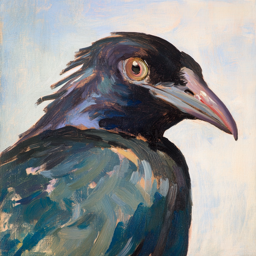

In [4]:
img = Image.open('./notebooks/assets/example_image.png').resize((256,256)).convert('RGB')
img_tensor = TF.to_tensor(img).to(device).unsqueeze(0) * 2 - 1
print(img_tensor.shape)
img

In [5]:
tokens, _ = image_tokenizer.encode(img_tensor)
print(tokens.shape)
print(tokens)

torch.Size([1, 16, 16])
tensor([[[28881, 29123, 51352, 46978, 15633, 41412, 34500, 37187, 50499, 51010,
          42312, 25880,  3273, 44355, 16258, 25857],
         [42252, 62285, 44366, 48964, 55558, 57986, 46611,   674, 14872, 26832,
          10762, 59852, 44226, 53704, 13410, 49874],
         [38610, 54147, 42317, 51586, 17048, 36514, 21356, 37277, 10029, 36590,
          43897, 57864,  7873, 31120, 18897, 53964],
         [63246, 48393, 54595, 21145, 22300, 21301, 63453, 47790, 44660, 10610,
          25062, 32631, 57072, 49926, 54988, 29829],
         [52441, 41410, 13977, 57429,  6699, 36129, 14173, 51705, 24746,   740,
          32238, 42274, 24045, 16000, 28609, 51522],
         [61324, 16067, 52771, 21149,  7915, 58836, 32547,  9886,  6393, 46764,
           6742, 62249, 32348, 47985, 24065, 13131],
         [25988, 51338, 36228, 18173, 50124,  3363, 18851, 15772, 51023, 42979,
          31994, 36428,  8504,  7905, 56801, 17986],
         [55050, 32793, 50285, 50075, 38955, 

Let's reconstruct using the tokenizer's decoder and plot the original and reconstructed image side-by-side. As you can observe, the tokenizer reconstruction does not preserve pixel-perfect details, but gives us a more semantic encoding of the image. For example, the brush strokes are not exactly the same, but they are in a similar style. Or the bird's eye is still very much recognizable as an eye, but abstracts away more nuanced details about it. Generally the reconstruction fidelity can be improved by increasing the input image size (e.g. a 512x512 pixel image gets mapped into 32x32 tokens here), changing the tokenizer to use a smaller spatial compression ratio (e.g. from 16x reduction of each side to only an 8x reduction), or by increasing the vocabulary size (e.g. increasing it beyond 64000). The first two techniques result in larger sequence lengths, while the third increases the size of the input embedding and to_logit projection layers. In our examples we will stick with a decent middle-ground - encoding 256x256 pixel images into 16x16 tokens of vocabulary size 64000).

In [6]:
reconst = image_tokenizer.decode(tokens).float().clamp(-1,1)
reconst.shape

torch.Size([1, 3, 256, 256])

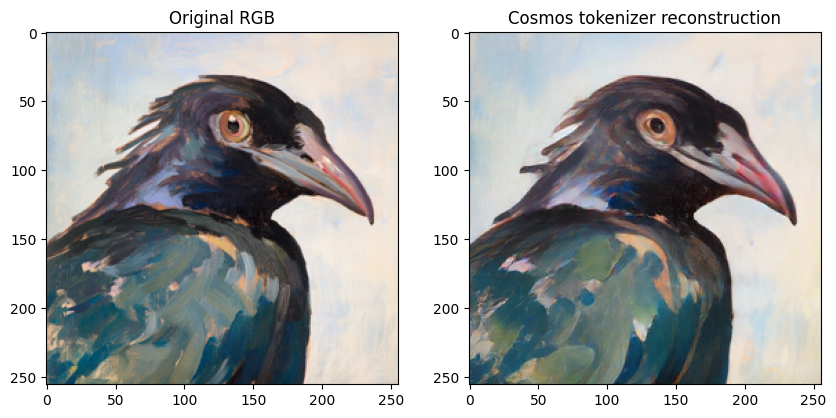

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
ax[0].imshow(img)
ax[0].set_title('Original RGB')
ax[1].imshow(reconst[0].cpu().permute(1,2,0) / 2 + 0.5)
ax[1].set_title('Cosmos tokenizer reconstruction')
plt.show()

### 2.3 Multimodal masked dataset

As mentioned above, we will train on a multimodal version of CLEVR. As a general rule when training generative models on top of tokens, we want to spend as much of the GPU's FLOPS on the actual model training, and not on encoding the various modalities. While the tokenizer overhead can be manageable with a single modality and a small tokenizer encoder, it can quickly get out of hand with multiple modalities. For this reason, we provide a pre-tokenized dataset, which also has the benefit of being significantly more compact than the original images. 

In `nanofm/data/multimodal/simple_multimodal_dataset.py` we define a simple multimodal dataset that loads these tokens from the disk. Feel free to take a look. This dataloader merely loads the tokens, but since we are training a model with a multimodal masking scheme, we also need to perform that masking logic somewhere. We could perform it inside the actual model's forward pass, but it is cleaner and easier to perform that logic within a transform that is applied to each sample individually. Please see `nanofm/data/multimodal/masking.py` for the masking logic. We will discuss it more in the following on some concrete examples.

For that, let us first define some helper functions for plotting samples form the dataset.

In [8]:
def token_ids_to_image(token_ids, image_tokenizer, to_pil=False):
    n_tokens = token_ids.numel()
    side = int(math.sqrt(n_tokens))
    token_ids = token_ids.reshape(1,side,side).to(device)
    reconst = image_tokenizer.decode(token_ids)
    reconst = (reconst[0].clamp(-1,1).float().cpu() + 1) / 2
    if to_pil:
        reconst = TF.to_pil_image(reconst)
    return reconst

def get_modality_with_mask(data_dict, mod_name, mask_type=None):
    tokens = data_dict['unmasked_data_dict'][mod_name].clone()
    L = tokens.shape[0]
    if mask_type == 'input':
        modality_mask = data_dict['enc_modalities'] == modalities.index(mod_name)
        modality_mask = modality_mask & data_dict['enc_pad_mask']
        modality_indices = data_dict['enc_positions'][modality_mask]
    elif mask_type == 'target':
        modality_mask = data_dict['dec_modalities'] == modalities.index(mod_name)
        modality_mask = modality_mask & data_dict['dec_pad_mask']
        modality_indices = data_dict['dec_positions'][modality_mask]
    elif mask_type is None:
        modality_indices = torch.arange(L)
    else:
        raise ValueError()
    mask = torch.zeros(L, dtype=torch.bool)
    mask[modality_indices] = True # True = input, False = masked out
    return tokens, mask

def get_masked_image(img, mask):
    mask = mask.reshape(1,1,16,16).float()
    mask = F.interpolate(mask, (256,256), mode='nearest')[0,0].bool()
    img[:,~mask] = 0
    img = img.permute(1,2,0)
    return img

def plot_data_dict_with_mask(data_dict, mask_type=None):
    # Scene description
    tokens, mask = get_modality_with_mask(data_dict, 'scene_desc', mask_type=mask_type)
    n_scene_desc = mask.sum().item()
    tokens[~mask] = 62 # Simply plot masked out regions as underscores
    print(f'Scene description: {dataset.text_tokenizer.decode(tokens)}\n\n')
    
    fig = plt.figure(figsize=(10,4))
    grid = ImageGrid(fig, 111, nrows_ncols=(1, 3), axes_pad=0.1)
    
    # RGB
    tokens, mask = get_modality_with_mask(data_dict, 'tok_rgb@256', mask_type=mask_type)
    n_rgb = mask.sum().item()
    img = get_masked_image(token_ids_to_image(tokens, image_tokenizer), mask)
    grid[0].imshow(img)
    grid[0].set_title('RGB')
    
    # Depth
    tokens, mask = get_modality_with_mask(data_dict, 'tok_depth@256', mask_type=mask_type)
    n_depth = mask.sum().item()
    img = get_masked_image(token_ids_to_image(tokens, image_tokenizer), mask)
    grid[1].imshow(img)
    grid[1].set_title('Depth')
    
    # Normals
    tokens, mask = get_modality_with_mask(data_dict, 'tok_normal@256', mask_type=mask_type)
    n_normal = mask.sum().item()
    img = get_masked_image(token_ids_to_image(tokens, image_tokenizer), mask)
    grid[2].imshow(img)
    grid[2].set_title('Normals')
    
    plt.show()
    
    if mask_type is not None:
        print()
        print(f'Num. scene_desc tokens: {n_scene_desc}')
        print(f'Num. tok_rgb@256 tokens: {n_scene_desc}')
        print(f'Num. tok_depth@256 tokens: {n_depth}')
        print(f'Num. tok_normal@256 tokens: {n_normal}')
        print('-'*32)
        total_tokens = n_scene_desc + n_rgb + n_depth + n_normal
        print(f'Total tokens: {total_tokens}')

Furthermore, let us define the mask transform and the dataset.

In [9]:
modalities = ['tok_rgb@256', 'tok_depth@256', 'tok_normal@256', 'scene_desc']
vocab_sizes = [64000, 64000, 64000, 50304]
max_seq_lens = [256, 256, 256, 256]

In [10]:
mask_transform = SimpleMultimodalMasking(
    modalities=modalities,
    vocab_sizes=vocab_sizes,
    max_seq_lens=max_seq_lens,
    input_alphas=[1.0, 1.0, 1.0, 1.0],
    target_alphas=[1.0, 1.0, 1.0, 1.0],
    input_tokens_range=(1,128),
    target_tokens_range=(1,128),
    overlap_vocab=True,
    overlap_posembs=True,
    include_unmasked_data_dict=True,
)

In [11]:
dataset = SimpleMultimodalDataset(
    root_dir='/work/com-304/datasets/clevr_com_304/',
    split='train',
    modalities=modalities,
    sample_from_k_augmentations=10,
    text_tokenizer_path='gpt2',
    text_max_length=256,
    transforms=mask_transform,
)

Now that we defined the dataset and masking function, let's look at an example. The training objective of 4M is to predict *one random subset of tokens of all modalities from another random subset*. These subsets don't overlap, i.e. no target token can be in the input too (otherwise the model may simply copy the information).

We first show the original data for the four modalities, without any masks. The second row below shows the input to the encoder, and the third row shows the target, i.e. what we train the model to predict given the input.

To create the masks, we first randomly sample the number of input and target tokens for each modality, given a certain input and target token budget. In other words, let's say we want to always have 128 tokens in the input and 128 tokens in the output, such that we can batch multiple random samples efficiently. If we define that number, the first task is to randomly assign how many tokens we will randomly sample from each modality to fulfill that 128 token input/output budget. We do that by sampling from a Dirichlet distribution (see https://multimae.epfl.ch/). Once we have the number of input and target tokens for each modality, we simply draw tokens uniformly at random from the modalities according to those budgets.

########## Original non-masked data ##########

Scene description: [SOS]Object 1 - Position: x=84 y=50 Shape: cube Color: blue Material: metal. Object 2 - Position: x=65 y=34 Shape: sphere Color: cyan Material: rubber. Object 3 - Position: x=48 y=43 Shape: sphere Color: purple Material: metal. Object 4 - Position: x=54 y=60 Shape: cylinder Color: gray Material: rubber. Object 5 - Position: x=74 y=40 Shape: cylinder Color: brown Material: rubber. [EOS][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD]

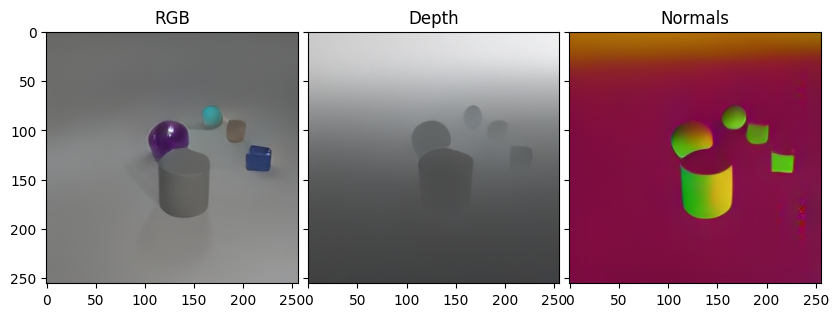



########## Inputs ##########

Scene description: ________________________________________________________________ Object_________60____________ -________________________________________________________[PAD]__[PAD]____[PAD]__________________________________________________________________[PAD]____________________________________




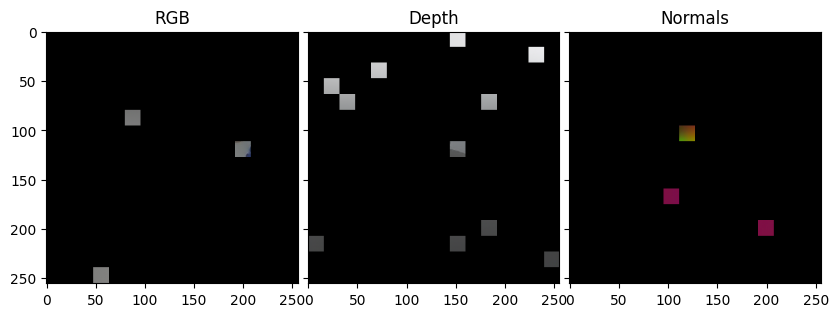


Num. scene_desc tokens: 7
Num. tok_rgb@256 tokens: 7
Num. tok_depth@256 tokens: 11
Num. tok_normal@256 tokens: 3
--------------------------------
Total tokens: 24


########## Targets ##########

Scene description: _____________________._______________________________43________ metal_______________________________=__________________________[PAD]___________________________________[PAD]_______________[PAD]__[PAD]____[PAD][PAD]_________________[PAD]____________________________[PAD]_______________________[PAD]_[PAD]




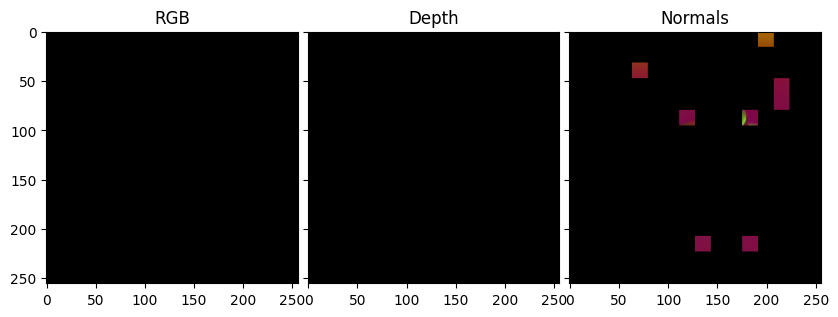


Num. scene_desc tokens: 14
Num. tok_rgb@256 tokens: 14
Num. tok_depth@256 tokens: 0
Num. tok_normal@256 tokens: 8
--------------------------------
Total tokens: 22


In [12]:
data_dict = dataset[0]

print('#'*10 + ' Original non-masked data ' + '#'*10 + '\n')
plot_data_dict_with_mask(data_dict, mask_type=None)

print('\n\n' + '#'*10 + ' Inputs ' + '#'*10 + '\n')
plot_data_dict_with_mask(data_dict, mask_type='input')

print('\n\n' + '#'*10 + ' Targets ' + '#'*10 + '\n')
plot_data_dict_with_mask(data_dict, mask_type='target')

Feel free to load a few examples, inspect the original un-masked data_dict, and try to understand what everything means. Please also check out https://multimae.epfl.ch/ and https://4m.epfl.ch/ for more details on the multimodal training objective.

Let's dig deeper into how we provide that information to the model. From the perspective of the encoder, we need to pass three types of information:

1. **What** content or information does a particular token contain? This is simply the token ID we get from the tokenizer, and inside nano4M we learn an Embedding layer to map those indices to vectors.
2. **Where** is that token from? I.e. what's the token's x,y location in the 2D token grid, or the position in the 1D sequence of text tokens? We simplify this by just considering the token position index of flattened sequences. All image-like modalities are 16x16 tokens flattened to 256 tokens, and the scene description is also at most 256 tokens. Inside nano4M, we simply use sin-cos positional embeddings to specify that position to the model.
3. **What** modality is that token? We simplify the design of nano4M by using a single unified vocabulary for all modalities. That means that the i-th vocabulary entry can be reused for all modalities, and have a different meaning for each. To disambiguate if the i-th token came from e.g. normals or the scene description, we simply learn a modalty embedding in nano4M.

First, let's plot the modality indices for the random subset of tokens that gets encoded. Here the indices correspond to the above modalities variable `['tok_rgb@256', 'tok_depth@256', 'tok_normal@256', 'scene_desc']`, i.e. index 0 is RGB, 1 is depth, and so on.

Note: Notice that the last few tokens are 0's too. These are place-holder indices for padding tokens, i.e. they are not used. Later we will look at the encoder and decoder padding masks that are used to ignore these positions.

In [13]:
data_dict['enc_modalities']

tensor([0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])

At these positions we pass the token information / the actual content describing *what* the input contains.

In [14]:
data_dict['enc_tokens']

tensor([21971,  7898, 32204, 44865, 46272, 31681, 20929,  3531, 44165, 28268,
        26014, 54615, 15829,  8677, 17668,  2742, 28523,  9515,  1899,   532,
        50257, 50257, 50257, 50257,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0])

And as described above, we need to let the model know where these tokens came from in each sequence, such that we can look up the corresponding positional embedding.

In [15]:
data_dict['enc_positions']

tensor([ 85, 124, 243,   9,  30,  36,  49,  66,  75, 121, 203, 208, 217, 239,
        103, 166, 204,  64,  74,  87, 144, 147, 152, 219,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0])

As a side-note, we also pass masks that indicate padding tokens if the encoder tokens don't fill up the token budget. (We do the same for the decoder.) For both, True = a token is used, False = a token is padding and should not be attended to (and no loss should be computed on it).

In [16]:
data_dict['enc_pad_mask']

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False])

From the perspective of the decoder, we need to tell it where we want to predict (or read out) a token, and for which modality. This is basically the same as in the encoder, but this time we don't pass the token information into the decoder (since that's what we want to predict!) Instead, we need it as the target, i.e. for computing the loss. See the following tensors.

Note: For the `'dec_tokens'` tensor, we use `-100` as the padding index. We use this to signify which tokens to ignore in the cross-entropy loss calculation. For the other tensors we use `0`, since it doesn't matter much what we put when these positions are ignored in the attention masks.

In [17]:
data_dict['dec_modalities']

tensor([2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])

In [18]:
data_dict['dec_positions']

tensor([ 12,  36,  61,  77,  87,  91, 216, 219,  21,  53,  62,  94, 121, 157,
        173, 176, 181, 182, 200, 229, 253, 255,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0])

In [19]:
data_dict['dec_tokens']

tensor([ 2394, 16243, 41331, 28586, 41267, 51253, 31083, 28523,    13,  3559,
         6147,    28, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
        50257, 50257,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100])

In [20]:
data_dict['dec_pad_mask']

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False])

---

## 3 Building nano4M

To implement nano4M, we ask you to complete the subsections below by directly filling in the missing lines in the code base.

### 3.1 (Masked) cross-attention layer (20 points)

First, let's implement an (optionally masked) multi-headed cross-attention layer in `nanofm.modeling.transformer_layers.CrossAttention`.
We will need this for the Transformer decoder to attend to the encoded tokens using cross-attention.

This layer is very similar to the already implemented self-attention layer, with the difference that the queries are produced by the input sequence $X \in \mathcal{R}^{N \times D}$ ($N$ tokens of dimension $D$), while the keys and values are produced by the context $C \in \mathcal{R}^{M \times D}$ ($M$ tokens of dimension $D$).
The queries $Q$ are linear projections of $X$, while the keys $K$ and the values $V$ are both linear projections of $C$.

$$ Q(X) = X W_Q^T $$
$$ K(C) = C W_K^T $$
$$ V(C) = C W_V^T $$


The scaled dot-product attention then given these queries, keys and values is the same:
$$ \text{Attention}(Q, K, V) = \text{softmax}_\text{row} \left( \frac{Q K^T}{\sqrt{d_k}} \right) V $$

The scaling factor $d_k$ is the dimensionality of the keys $K$, i.e. `dim // num_heads`.

The attention is performed on `num_heads` heads in parallel (don't use a for loop) in `head_dim = dim // num_heads`-dimensional subspaces and the results are concatenated along the feature dimension.

In addition, we want to enable masking of the attention matrix, e.g. for preventing the cross-attention to attend to encoder padding tokens.
For this, the forward function takes an additional `mask` argument, specifying where to zero-out the attention matrix.
In practice, this is implemented by replacing the values of the attention matrix (pre softmax) to minus infinity wherever we don't want any attention flow.

### 3.2 Transformer decoder block (10 points)

Next, implement a Transformer decoder block in `nanofm.modeling.transformer_layers.DecoderBlock`. It is defined as:

$$ X_a = X + \text{Self-Attention}(\text{LN}(X)) $$
$$ X_b = X_a + \text{Cross-Attention}(\text{LN}(X_a), \text{LN}(C)) $$
$$ X_c = X_b + \text{MLP}(\text{LN}(X_b)) $$

Here, $\text{LN}$ denotes (four separate) LayerNorm layers.

Don't forget to pass the optional self-attention (sa) mask to the self-attention layer, and cross-attention (xa) mask to the cross-attention layer!

### 3.3 Assembling the blocks into a Transformer decoder tunk (10 points)

Now we have all the building blocks to create a Transformer decoder trunk! 

In `nanofm.modeling.transformer_layers.TransformerDecoderTrunk`, create an `torch.nn.ModuleList` containing multiple Transformer decoder blocks, and in the forward pass call them one after another.
Again, make sure to pass the masks!

### 3.4 Initialize nano4M (10 points)

Now we have all the building blocks to construct an encoder-decoder Transformer and make it multimodal. We will implement it in `nanofm.models.fourm.FourM`.
Please initialize the following modules in the constructor:
1. The input tokens (from `data_dict['enc_tokens']`) are embedded with an `nn.Embedding` layer. Initialize `self.enc_tok_emb` accordingly, taking into account the vocabulary size `self.vocab_size`.
2. Different from the previous notebooks, we use fixed 1D sine-cosine positional embeddings, which are initialized in `self.pos_emb`. We already provide that step for you.
3. Since we use a shared vocabulary, we need to tell the encoder from which modality each token stems. For that, we learn another `nn.Embedding` layer. Initialize `self.enc_mod_emb` accordingly, taking into account the number of modalities `self.num_modalities`.
4. The sum of the token embedding, positional embedding, and modality embedding gets passed to a standard Transformer encoder trunk. Initialize `self.encoder` with the Transformer trunk from weeks 1 and 2.
5. After encoding these tokens, we pass the encoder output through a LayerNorm and a projection from the encoder's dimension to the decoder's (which are the same). Initialize `self.enc_norm` and `self.dec_context_proj`. This concludes the setup for the encoder.
6. For the decoder we need to specify where we want to predict each token (using the same fixed positional embeddings mentioned before), and for which modality. For the latter, let's initialize another `nn.Embedding` layer as `self.dec_mod_emb`, similar to `self.enc_mod_emb`.
7. The sum of the position and modality embeddings to decode gets passed through a Transformer decoder layer. Using the TransformerDecoderTrunk you implemented, initialize `self.decoder`.
8. Finally we project the decoder output through a LayerNorm and output projection that maps the elements from the Transformer dimension to the vocabulary size `self.vocab_size` (as a one-hot vector per token). Initialize `self.dec_norm` and `self.to_logits`. The bias term for `self.to_logits` should always be set to False.

### 3.5 nano4M encoder forward (10 points)

Next, implement the `forward_encoder` function:
1. The input to the encoder is the sum of the encoder input token embeddings, corresponding position embeddings, and corresponding modality embeddings.
2. Pass this tensor through the encoder, making sure to pass the optional self-attention mask.
3. Pass the encoder output through the encoder norm layer.

### 3.6 nano4M decoder forward (10 points)

Next, implement the `forward_decoder` function:
1. The input to the decoder is the sum of the target position embeddings, and corresponding modality embeddings.
2. Pass this tensor through the decoder, making sure to pass the optional self-attention and cross-attention masks.
3. Pass the decoder output through the decoder norm layer.

In `forward_model`, project that decoder output to the vocabulary logits using `self.to_logits`.

### 3.7 Generation (10 points)

4M defines two decoding schemes to generate the desired targets: 

#### MaskGIT-style decoding
This decoding scheme is pretty much the same as the one you implemented in part 2 for MaskGIT, with the difference that we now use an encoder-decoder Transformer instead of an encoder-only Transformer. That means the encoder exclusively processes "visible/input" tokens, while the decoder is in charge of processing the mask tokens to predict the missing regions. Like with MaskGIT, in this scheme we always decode all remaining masked-out tokens and pick the $k$ most confident ones to sample from.

#### Random Order Auto-Regressive (ROAR) decoding
With 4M, we can decode tokens in a slightly different way. Rather than always decoding all masked-out tokens and then sampling the top-k most confident ones, we can instead randomly sample k token positions to decode and only process those in the decoder. This simplifies some of the considerations on *how* we even decide which tokens are the most confident ones in MaskGIT. This decoding scheme has recently been adopted in [MAR](https://arxiv.org/abs/2406.11838).

In this task, we ask you to implement the ROAR decoding scheme in `generate_one_modality_roar`, focusing on generating a single modality given any input. Specifically it works in the following way:
1. The function expects the input tokens, their positions, and their modality. Given the desired number of decoding steps and target modality, it performs the iterative unmasking and returns the predicted tokens, as well as the original inputs concatenated with the predicted tokens/positions/modalities (to be used as input when generating other modalities in a chained manner).
2. Given the desired number of decoding steps, it computes the number of tokens $k$ to predict at each step (i.e. the schedule).
3. During each decoding step we select a random set of $k$ positions to decode, which are simply position indices between 0 and the maximum number of tokens (255 for each modality). These desired target positions to predict, alongside the corresponding target modality indices, are fed through the decoder to get the logits for those $k$ tokens. 
4. We then simply sample the token indices from these tokens. To prepare the input for the next round, we simply concatenate the predicted tokens with the encoder input tokens, the predicted positions with the encoder input positions, and the predicted modality ids with the input modality ids. 
5. After all the generation steps are done, we select the predicted subset of tokens, unshuffle it and return it.
6. With the generated sequence so far, we can then simply input that into the same function to generate the next modalities in a chained manner.

### 3.8 Training the model

We defined a training config for you in: `nano4M_sol/cfgs/nano4M/multiclevr_d6-6w512.yaml`. Please familiarize yourself with all parts.
Please don't forget to replace the Weights & Bias entity with your own.

This config is expected to be run on 4 V100 GPUs. That said, on SCITAS most nodes have 2 V100s, not 4. For that reason, we ask you to start the training jobs with the prepared multinode script (`submit_job_multi_node_scitas.sh`) in the root directory. 
(Just for reference, on a single 4xV100 node, you could start the training like: `OMP_NUM_THREADS=1 torchrun --nproc_per_node=4 run_training.py --config cfgs/nano4M/multiclevr_d6-6w512.yaml`. This command won't work for multi-node training; you should use the aforementioned script.)

Training on 4 V100s should take around 5 hours. You should reach a final validation loss around 3.5, and your loss curves should look something like the following:

<img src="./assets/nano4M_clevr.png" alt="nano4M CLEVR loss curves" width="1500">

### 3.9 Show your loss curves (10 points)

Screenshot your loss curves and show them here. Add the image to the `assets` directory and change the path in the markdown. You will get 10 points for reasonable loss curves (similar to the sample loss curves above).

<img src="./assets/notebook03_wandb_screen.png" alt="nano4M CLEVR loss curves" width="1500">

---

## 4 Inference

Let's load the trained model and check that we can perform any-to-any prediction!

### 4.1 Evaluating the model (10 points)

After you completed the training, load the model with the following cell. You may need to adjust the path if you changed it.
You will get 10 points if the outputs look reasonable (similar to the sample outputs provided below).

Hint: You can also load intermediate safetensors checkpoints to check the progress during training.

In [21]:
ckpt_path = './outputs/nano4M/multiclevr_d6-6w512/checkpoint-final.safetensors'
model = load_model_from_safetensors(ckpt_path, device=device)
print(f'{model.get_num_params() / 10**6}M parameters')

44.322304M parameters


To test the model, let's load some (unmasked) samples from the validation set:

In [22]:
dataset = SimpleMultimodalDataset(
    root_dir='/work/com-304/datasets/clevr_com_304/',
    split='val',
    modalities=modalities,
    sample_from_k_augmentations=1,
    text_tokenizer_path='gpt2',
    text_max_length=256,
    transforms=None, # No transforms
)

def construct_input_from_sample(dataset, idx, input_modality):
    input_tensor = dataset[idx][input_modality]
    n_tokens_input = input_tensor.shape[0]
    enc_input_tokens = input_tensor.unsqueeze(0).to(device)
    enc_input_positions = torch.arange(n_tokens_input, device=device).unsqueeze(0)
    enc_input_modalities = modalities.index(input_modality) * torch.ones(1, n_tokens_input, device=device, dtype=torch.long)
    return enc_input_tokens, enc_input_positions, enc_input_modalities

def show_modality(tokens, modality):
    if modality == 'scene_desc':
        print(dataset.text_tokenizer.decode(tokens[0]))
    else:
        token_ids_to_image(tokens, image_tokenizer, to_pil=True).show()

#### Example: RGB -> Depth -> Normals -> Scene description

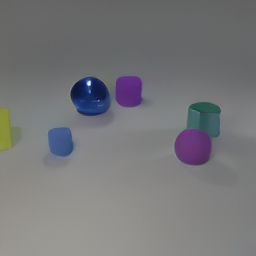

In [23]:
input_modality = 'tok_rgb@256'
sample_idx = 0

x_tokens, x_positions, x_modalities = construct_input_from_sample(dataset, idx=sample_idx, input_modality=input_modality)
show_modality(x_tokens, input_modality)

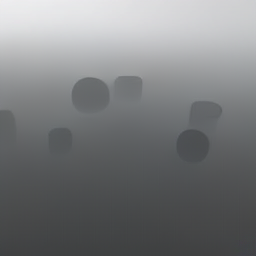

In [24]:
target_mod = 'tok_depth@256'
num_steps, temp, top_p, top_k = 8, 0.001, 0.0, 0.0

pred_tokens, x_tokens, x_positions, x_modalities = model.generate_one_modality_roar(
    x_tokens, x_positions, x_modalities, target_mod=target_mod,
    num_steps=num_steps, temp=temp, top_p=top_p, top_k=top_k,
)
show_modality(pred_tokens, target_mod)

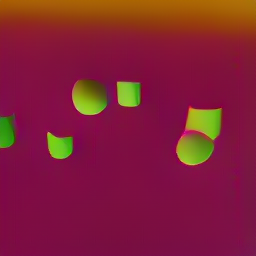

In [25]:
target_mod = 'tok_normal@256'
num_steps, temp, top_p, top_k = 8, 0.001, 0.0, 0.0

pred_tokens, x_tokens, x_positions, x_modalities = model.generate_one_modality_roar(
    x_tokens, x_positions, x_modalities, target_mod=target_mod,
    num_steps=num_steps, temp=temp, top_p=top_p, top_k=top_k,
)
show_modality(pred_tokens, target_mod)

In [26]:
target_mod = 'scene_desc'
num_steps, temp, top_p, top_k = 128, 0.7, 0.9, 0.0

pred_tokens, x_tokens, x_positions, x_modalities = model.generate_one_modality_roar(
    x_tokens, x_positions, x_modalities, target_mod=target_mod,
    num_steps=num_steps, temp=temp, top_p=top_p, top_k=top_k,
)
show_modality(pred_tokens, target_mod)

[SOS]Object 1 - Position: x=79 y=37 Shape: sphere Color: cyan Material: metal. Object 2 - Position: x=80 y=48 Shape: cylinder Color: purple Material: metal. Object 3 - Position: x=78 y=40 Shape: sphere Color: blue Material: metal. Object 4 - Position: x=25 y=37 Shape: cylinder Color: red Material: metal. Object 5 - Position: x=25 y=55 Shape: sphere Color: blue Material: metal. Object 6 - Position: x=77 y=47 Shape: sphere Color: blue Material: metal. [EOS][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][

#### Example: Scene description -> Normals -> Depth -> RGB

In [27]:
input_modality = 'scene_desc'
sample_idx = 0

x_tokens, x_positions, x_modalities = construct_input_from_sample(dataset, idx=sample_idx, input_modality=input_modality)
show_modality(x_tokens, input_modality)

[SOS]Object 1 - Position: x=35 y=37 Shape: sphere Color: blue Material: metal. Object 2 - Position: x=79 y=47 Shape: cylinder Color: cyan Material: metal. Object 3 - Position: x=-2 y=50 Shape: cube Color: yellow Material: rubber. Object 4 - Position: x=50 y=35 Shape: cylinder Color: purple Material: rubber. Object 5 - Position: x=75 y=56 Shape: sphere Color: purple Material: rubber. Object 6 - Position: x=24 y=55 Shape: cylinder Color: blue Material: rubber. [EOS][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][P

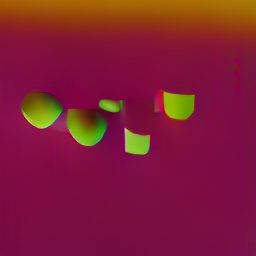

In [28]:
target_mod = 'tok_normal@256'
num_steps, temp, top_p, top_k = 128, 0.7, 0.9, 0.0

pred_tokens, x_tokens, x_positions, x_modalities = model.generate_one_modality_roar(
    x_tokens, x_positions, x_modalities, target_mod=target_mod,
    num_steps=num_steps, temp=temp, top_p=top_p, top_k=top_k,
)
show_modality(pred_tokens, target_mod)

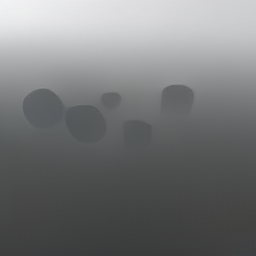

In [29]:
target_mod = 'tok_depth@256'
num_steps, temp, top_p, top_k = 32, 0.7, 0.9, 0.0

pred_tokens, x_tokens, x_positions, x_modalities = model.generate_one_modality_roar(
    x_tokens, x_positions, x_modalities, target_mod=target_mod,
    num_steps=num_steps, temp=temp, top_p=top_p, top_k=top_k,
)
show_modality(pred_tokens, target_mod)

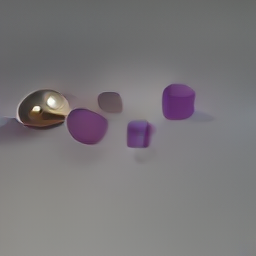

In [30]:
target_mod = 'tok_rgb@256'
num_steps, temp, top_p, top_k = 64, 0.7, 0.9, 0.0

pred_tokens, x_tokens, x_positions, x_modalities = model.generate_one_modality_roar(
    x_tokens, x_positions, x_modalities, target_mod=target_mod,
    num_steps=num_steps, temp=temp, top_p=top_p, top_k=top_k,
)
show_modality(pred_tokens, target_mod)

### 4.2 Open-ended questions (10 points each)

Please answer the following questions. You may use additional cells to demonstrate your answers if necessary.

#### 4.2.1 Improved scene description -> RGB chain and hyperparameters

Can you find a better set of generation hyperparameters (number of steps, temperature, top-k, top-p) and prediction chain to go from scene descriptions to RGB (using any or no intermediate modalities)? Show your results and observations below.

[SOS]Object 1 - Position: x=35 y=37 Shape: sphere Color: blue Material: metal. Object 2 - Position: x=79 y=47 Shape: cylinder Color: cyan Material: metal. Object 3 - Position: x=-2 y=50 Shape: cube Color: yellow Material: rubber. Object 4 - Position: x=50 y=35 Shape: cylinder Color: purple Material: rubber. Object 5 - Position: x=75 y=56 Shape: sphere Color: purple Material: rubber. Object 6 - Position: x=24 y=55 Shape: cylinder Color: blue Material: rubber. [EOS][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][P

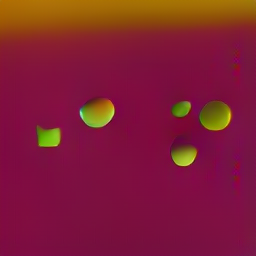

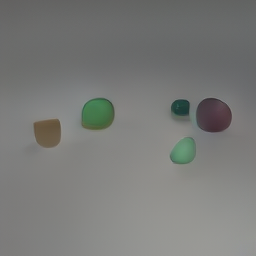

In [81]:
# Step 1: normals
first_step = {
    'target_mod': 'tok_normal@256',
    'num_steps': 80,
    'temp': 0.8,
    'top_p': 0.9,
    'top_k': 50,
}

# Step 2: depth
second_step = {
    'target_mod': 'tok_depth@256',
    'num_steps': 60,
    'temp': 0.6,
    'top_p': 0.85,
    'top_k': 100,
}

# Step 3: rgb
third_step = {
    'target_mod': 'tok_rgb@256',
    'num_steps': 128,
    'temp': 0.5,
    'top_p': 0.7,
    'top_k': 0,
}


input_modality = 'scene_desc'
sample_idx = 0
x_tokens, x_positions, x_modalities = construct_input_from_sample(
    dataset, idx=sample_idx, input_modality=input_modality
)
show_modality(x_tokens, input_modality)

cfg = first_step
pred_normals, x_tokens, x_positions, x_modalities = model.generate_one_modality_roar(
    x_tokens, x_positions, x_modalities,
    target_mod=cfg['target_mod'],
    num_steps=cfg['num_steps'],
    temp=cfg['temp'],
    top_p=cfg['top_p'],
    top_k=cfg['top_k']
)
show_modality(pred_normals, cfg['target_mod'])

#cfg = second_step
#pred_depth, x_tokens, x_positions, x_modalities = model.generate_one_modality_roar(
#    x_tokens, x_positions, x_modalities,
#    target_mod=cfg['target_mod'],
#    num_steps=cfg['num_steps'],
#    temp=cfg['temp'],
#    top_p=cfg['top_p'],
#    top_k=cfg['top_k']
#)
#show_modality(pred_depth, cfg['target_mod'])

cfg = third_step
pred_rgb, _, _, _ = model.generate_one_modality_roar(
    x_tokens, x_positions, x_modalities,
    target_mod=cfg['target_mod'],
    num_steps=cfg['num_steps'],
    temp=cfg['temp'],
    top_p=cfg['top_p'],
    top_k=cfg['top_k']
)
show_modality(pred_rgb, cfg['target_mod'])


What I’ve found is that, after experimenting with different numbers of intermediate steps, the normal-to-depth conversion isn’t strictly necessary, and skipping it can save some inference time.

It’s valuable to use a relatively high temperature and top-p for the first intermediate step, since this injects enough randomness to explore new forms. By running several decoding iterations at this stage, the model can generate more diverse structures. Then, once you have that intermediate output, you can lower the temperature and top-p—but still use many decoding steps to really hone and refine the final RGB result.

#### 4.2.2 Condition alignment

The alignment between condition and prediction can be quite poor sometimes, especially with the scene descriptions. What techniques could we apply during train and/or inference time to improve alignment and the overall generation quality?

In [32]:
# Fill your answer here

#### 4.2.3 Influence of number of decoding steps

How many decoding steps are needed to get decent results for different X → Y predictions? Test RGB → Normals, RGB → Scene Desc., and Scene Desc. → RGB. Why do some of these work well with very few steps and others not?

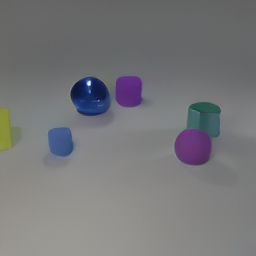

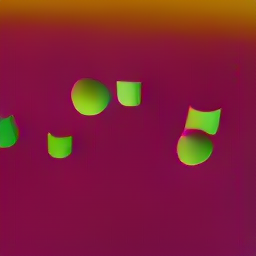

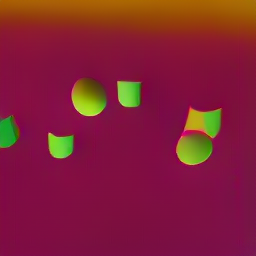

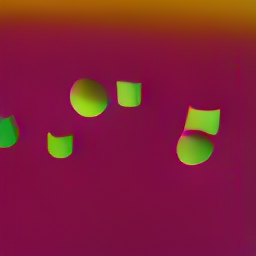

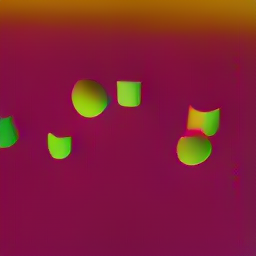

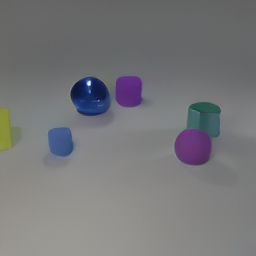

[SOS]Object 1 - Position: x=77 y=39 Shape: cylinder Color: green Material: metal. Object 2 - Position: x=0 y=35 Shape: cylinder Color: purple Material: rubber. Object 3 - Position: x=1 y=55 Shape: cylinder Color: blue Material: rubber. Object 4 - Position: x=1 y=49 Shape: sphere Color: purple Material: metal. Object 5 - Position: x=34 y=50 Shape: cube Color: purple Material: rubber. Object 6 - Position: x=[PAD] y=46 Shape[PAD][PAD][PAD]: blue Material: metal. [EOS][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][

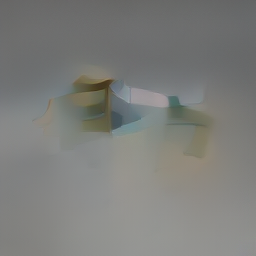

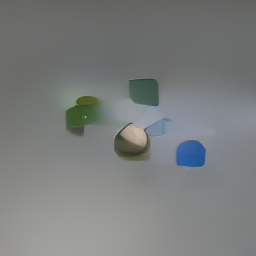

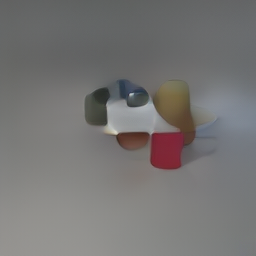

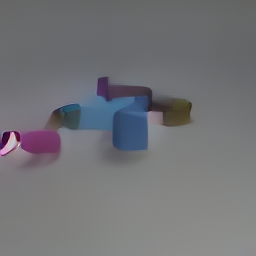

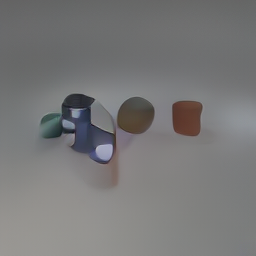

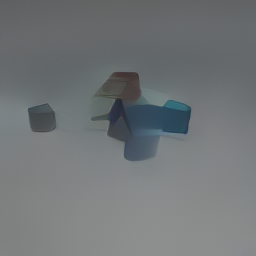

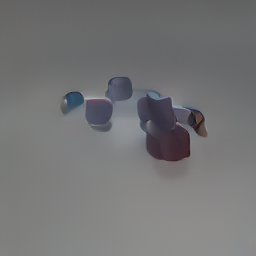

In [33]:
def test_decode_steps(initial_mod, target_mod, steps, sample_idx=0, temp=0.7, top_p=0.9, top_k=0.0):
    x_tokens, x_positions, x_modalities = construct_input_from_sample(
        dataset, idx=sample_idx, input_modality=initial_mod
    )

    show_modality(x_tokens, initial_mod)
    for n in steps:
        preds, _, _, _ = model.generate_one_modality_roar(
            x_tokens, x_positions, x_modalities,
            target_mod=target_mod,
            num_steps=n, temp=temp, top_p=top_p, top_k=top_k
        )
        show_modality(preds, target_mod)

rgb_to_normals = test_decode_steps(
    'tok_rgb@256', 'tok_normal@256',
    steps=[1,2,4, 8],
    temp=0.001, top_p=0.0, top_k=0.0
)

rgb_to_scene = test_decode_steps(
    'tok_rgb@256', 'scene_desc',
    steps=[1,8,16,64, 128],
    temp=0.7, top_p=0.9, top_k=0.0
)

scene_to_rgb = test_decode_steps(
    'scene_desc', 'tok_rgb@256',
    steps=[2,8, 16, 32, 64, 128,256],
    temp=0.7, top_p=0.9, top_k=0.0
)

### 4.3 Train a nano4M model with captions (Bonus, 20 points)

So far we trained nano4M with scene descriptions, but we also prepared synthetically generated captions for you in `/work/com-304/datasets/clevr_com_304/{train,val,test}/caption/`. 
Train a nano4M model with all the previous modalities (RGB, depth, normals, scene descriptions) plus the new `caption` modality. Show Caption → Any, and Any → Caption generation results.

In [34]:
# Fill your answer here

## 5 Further reading

Here is some further reading material should you want to dive deeper on multimodal input & output models.
- [4M: Massively Multimodal Masked Modeling](https://4m.epfl.ch/)
- [MultiMAE: Multi-modal Multi-task Masked Autoencoders](https://multimae.epfl.ch/)
- [Unified-IO: A Unified Model for Vision, Language, and Multi-Modal Tasks](https://arxiv.org/abs/2206.08916)
- [Unified-IO 2: Scaling Autoregressive Multimodal Models with Vision, Language, Audio, and Action](https://arxiv.org/abs/2312.17172)
- [UniDisc: Unified Multimodal Discrete Diffusion](https://unidisc.github.io/)
- [CM3: A Causal Masked Multimodal Model of the Internet](https://arxiv.org/abs/2201.07520)
- [Chameleon: Mixed-Modal Early-Fusion Foundation Models](https://arxiv.org/abs/2405.09818)
- [Transfusion: Predict the Next Token and Diffuse Images with One Multi-Modal Model](https://arxiv.org/abs/2408.11039)
- [LMFusion: Adapting Pretrained Language Models for Multimodal Generation](https://arxiv.org/abs/2412.15188)
- [Janus-Pro: Unified Multimodal Understanding and Generation with Data and Model Scaling](https://arxiv.org/abs/2501.17811)
- [Transframer: Arbitrary Frame Prediction with Generative Models](https://arxiv.org/abs/2203.09494)
- [MetaMorph](https://tsb0601.github.io/metamorph/)
- [Florence-2: Advancing a Unified Representation for a Variety of Vision Tasks](https://arxiv.org/abs/2311.06242)
- [GiT: Towards Generalist Vision Transformer through Universal Language Interface](https://arxiv.org/abs/2403.09394)
- [Lumina-mGPT: Illuminate Flexible Photorealistic Text-to-Image Generation with Multimodal Generative Pretraining](https://arxiv.org/abs/2408.02657)
- [Pix2seq: A Language Modeling Framework for Object Detection](https://arxiv.org/abs/2109.10852)
- [A Unified Sequence Interface for Vision Tasks](https://arxiv.org/abs/2206.07669)